#  GROVER'S ALGORITHM

Grover's algorithm can be used to find the solution(s) to a specific task by searching from a list of possible solutions in a quadratically faster time than a classical computer. The list of solutions is typically encoded in the quantum state $|s \rangle= H^{n}|00..0\rangle$, where each solution has an equal probability  weight.

The algorithm finds the solution by performing a process known as amplitude amplification. Conceptually, Grover's algorithm amplifies the amplitude of the winning state(s). State amplitudes are proportional to the square root of the probability to measure the corresponding state, hence why it can find a solution in approximately $\sqrt{N}$ steps, being $N$ the number of steps required by a classical algorithm. *Note that $N$ is also the number of possible solutions to the problem*

The amplitude amplification process consists of two steps, which can be understood as rotations in a plane [2]. The first step, performed by the *oracle*, rotates the initial state $|s \rangle$ around the states orthogonal to the winning state(s) $|w \rangle$, i.e. it flips the sign of the winning state(s). The second step, referred to as the Grover's diffuser, rotates the resulting state about $|s \rangle$, thus effectively increasing the amplitude of the winning state(s). By repeating this process $\sim \sqrt{N}$ times we obtain a wining state(s) amplitude(s) close to 1. Finally, the winning state(s) can be retrieved by measuring all the qubits, with the winning state(s) corresponding to the most likely outcome.


Refs.:

[1] Further details can be found in Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/grover.html#Contents

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [264]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import numpy as np
%matplotlib inline

In [266]:
# Load personal IBM account
IBMQ.load_account() 

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-01-10 13:43:45,606: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Initialization

The algorithm is initialized by acting with a Hadamard gate on each qubit

In [270]:
def initial_grover(circuit,qubits):
    
    # Apply a Hadamard gate on each qubit in the circuit
    for q in qubits:
        circuit.h(q)
    return circuit

### Oracle

The action of the oracle is that of flipping the sign of the winning state. The general approach is to transform the winning state(s) $|w \rangle \rightarrow |11..1 \rangle $ and then act with a multi-controlled-Z gate, obtaining $|11..1\rangle \rightarrow -|11..1\rangle$ and then transform back, yielding $-|11..1\rangle \rightarrow -|w\rangle$. 

In [307]:
def oracle(win_states):
    
    # Number of qubits, given by the size of the winning states
    nqubits = len(win_states[0]) 
    
    oracle = QuantumCircuit(nqubits)
    
    # For each winning state we create a circuit that flips its sign
    for state in win_states:
        
        # We reverse the order of the state to match the readout convention in Qiskit
        state = state[::-1]
        
        # Apply X-gates to obtain |11..1> state
        for qubit in range(nqubits):
            if state[qubit] == '0':
                oracle.x(qubit)
        
        # Apply Multi-Controlled-Z gate to flip sign of |11..1>
        oracle.h(nqubits-1)
        oracle.mct(list(range(nqubits-1)),nqubits-1)
        oracle.h(nqubits-1)
        
        # Apply X-gates to return to obtain -|w> state
        for qubit in range(nqubits):
            if state[qubit] == '0':
                oracle.x(qubit)
    
    # Return the oracle as a gate
    oc = oracle.to_gate()
    oc.name = 'U$_{or}$'
    
    return oc

Note that one drawback of creating a general oracle is that for cases with multiple solutions we will very likely perform  a non-optimal set of gate operations.

### Diffuser

The diffuser consist of a rotation around the initial state $|s \rangle= H^{n}|00..0\rangle$. This is performed by rotating the state such that any component along $|s\rangle$ is mapped into the $|00..0\rangle$ state, acting with Hadamard gates on each qubit. Next, we perform a rotation along $|00..0\rangle$, i.e. we flip the sign of each component except for $|00..0\rangle$. In general, this can be achieved by mapping $|00..0\rangle$ components into $|11..1\rangle$, acting with a multi-controlled-Z gate ($|11..1\rangle \rightarrow -|11..1\rangle$), and then mapping back to $|00..0\rangle$. Applying a set of Hadamard gates on each qubit we then return to the original basis having performed the rotation around $|s\rangle$ . *Note that this yields an overall minus sign.*

In [273]:
def diffuser(nqubits):
    
    circuit = QuantumCircuit(nqubits)
    
    # Rotate the state such that |s> -> |00..0> using H-gates
    for qubit in range(nqubits):
        circuit.h(qubit)
        
    # Transform |00..0> component into |11..1> using X-gates
    for qubit in range(nqubits):
        circuit.x(qubit)
        
    # Using multi-controlled-Z gate we give the |11..1> component (previously |00..0>) a relative sign
    # with respect to the other ones
    circuit.h(nqubits-1)
    circuit.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    circuit.h(nqubits-1)
    
    # Transform |11..1> component back into |00..0> using X-gates
    for qubit in range(nqubits):
        circuit.x(qubit)
        
    # Rotate the state back such that |00..0> -> |s> using H-gates
    for qubit in range(nqubits):
        circuit.h(qubit)
        
    # Return the diffuser as a gate
    U_diff = circuit.to_gate()
    U_diff.name = "U$_{diff}$"
    return U_diff

## Find a specifc state in a 3-qubit circuit

We pick our winner state to be $|110 \rangle $.

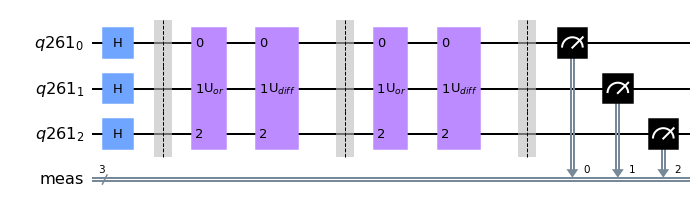

In [308]:
winning_states=['110']

num_qubits = len(winning_states[0])

# Main circuit
qr = QuantumRegister(num_qubits)
grover_circuit = QuantumCircuit(qr)

# Initialization
grover_circuit = initial_grover(grover_circuit,list(range(num_qubits)))

# Number of iterations
num_it = 2

# Add oracle and diffuser 'num_it' times
for x in range(num_it):
    grover_circuit.barrier()
    grover_circuit.append(oracle(winning_states),qr)
    grover_circuit.append(diffuser(num_qubits),qr)

# Perform measurements on all the qubits
grover_circuit.measure_all()

# Draw the complete circuit
grover_circuit.draw(output='mpl')

### Classical simulation 

In [309]:
sim_3cl = Aer.get_backend('qasm_simulator') # Define the backend
result_3cl = execute(grover_circuit, backend = sim_3cl, shots = 1024).result() # Execute the circuit in the backend

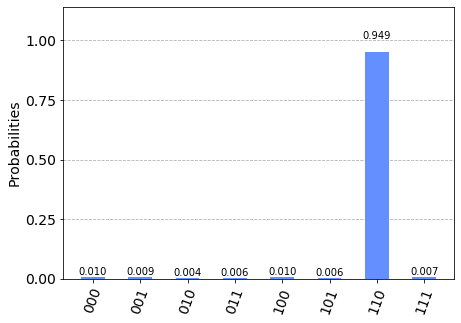

In [310]:
plot_histogram(result_3cl.get_counts())

We obtain the algorithm successfully finds the winning state $|110 \rangle $ using a classical simulator.

### Quantum simulation 

In [311]:
provider = IBMQ.get_provider(hub='ibm-q') # Choose provider
qcomp = provider.get_backend('ibmq_valencia') # Choose a specific quantum computer to run the circuit
grover_job = execute(grover_circuit,backend = qcomp) # Execute the circuit

print(grover_job.job_id())
job_monitor(grover_job)

5ffb31a2dc9dff191fc34dc0
Job Status: job has successfully run


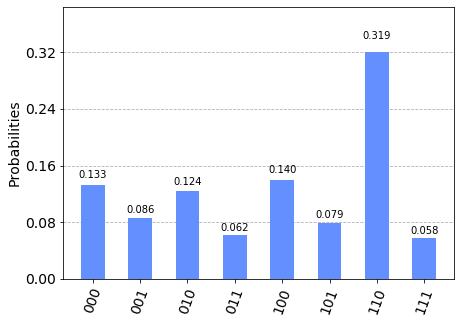

In [312]:
result_3q = grover_job.result()
plot_histogram(result_3q.get_counts())

We again obtain the algorithm successfully finds the winning state $|110 \rangle $. Given that we have now used a real device, we can appreciate the errors coming from the physical process in device. Despite this, the winning state can still be successfully found.

## Find a specifc state in a 5-qubit circuit

For fun, we now repeat this process but for a larger circuir, consisting of five qubits with $N=2^{5}=32$. We choose to search for two states instead of one, $|10001\rangle$ and $|00110\rangle$.

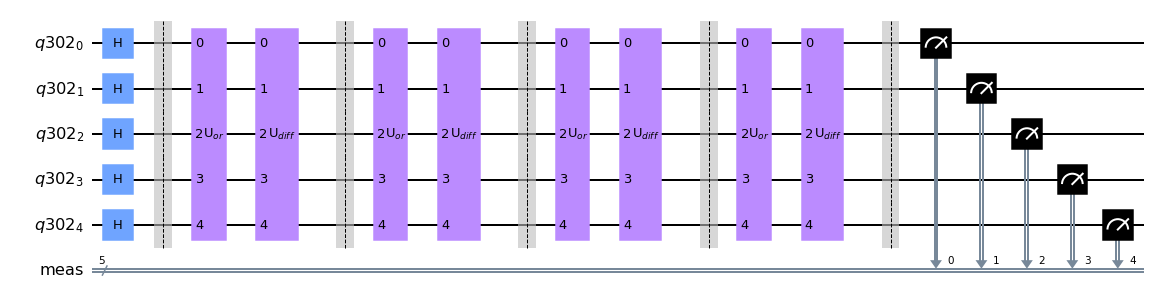

In [323]:
winning_states=['10001','00110']

num_qubits = len(winning_states[0])

# Main circuit
qr = QuantumRegister(num_qubits)
grover_circuit = QuantumCircuit(qr)

# Initialization
grover_circuit = initial_grover(grover_circuit,list(range(num_qubits)))

# Number of iterations
num_it = 4

# Add oracle and diffuser 'num_it' times
for x in range(num_it):
    grover_circuit.barrier()
    grover_circuit.append(oracle(winning_states),qr)
    grover_circuit.append(diffuser(num_qubits),qr)

# Perform measurements on all the qubits
grover_circuit.measure_all()

# Draw the complete circuit
grover_circuit.draw(output='mpl')

### Classical simulation 

In [324]:
sim_5cl = Aer.get_backend('qasm_simulator') # Define the backend
result_5cl = execute(grover_circuit, backend = sim_5cl, shots = 1024).result() # Execute the circuit in the backend

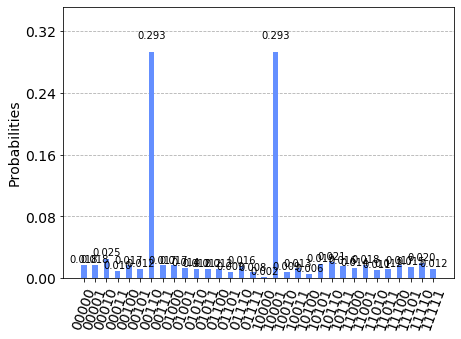

In [325]:
plot_histogram(result_5cl.get_counts())

As expected, the algorithm effectively finds multiple solutions too.

### Quantum simulation 

In [326]:
provider = IBMQ.get_provider(hub='ibm-q') # Choose provider
qcomp = provider.get_backend('ibmq_valencia') # Choose a specific quantum computer to run the circuit
grover_job5 = execute(grover_circuit,backend = qcomp) # Execute the circuit

print(grover_job5.job_id())
job_monitor(grover_job5)

5ffb351fdc9dff3ed6c34de3
Job Status: job has successfully run


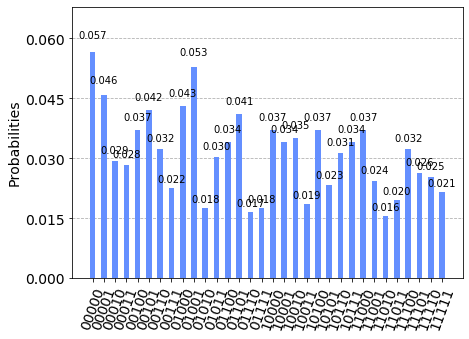

In [327]:
result_5q = grover_job5.result()
plot_histogram(result_5q.get_counts())

As opposed to the previous case, the quantum simulation on a real device is unable to identify the answer. This can be blamed on the non-optimal way of implementing the oracle given the size of the problem.